# 机器学习纳米学位毕业项目
## Rossmann 销售预测
Rossmann是欧洲的一家连锁药店。 在这个源自Kaggle比赛Rossmann Store Sales中，我们需要根据Rossmann药妆店的信息（比如促销，竞争对手，节假日）以及在过去的销售情况，来预测Rossmann未来的销售额。

数据集从Kaggle上下载，包含下列文件：train.csv （训练数据），test.csv(测试数据)，store.csv（门店信息），sample_submission.csv（Kaggle预测结果提交模板）。我们的目标是根据提供的1115家位于德国的门店历史销售数据，来预测未来6周每天每店的销售额。

## 探索数据

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # 允许为DataFrame使用display()
from datetime import datetime, date,timedelta

# 为notebook提供更加漂亮的可视化
%matplotlib inline


In [3]:

# load soure data
store = pd.read_csv("store.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

D:\Software\Anaconda2\envs\py2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 数据可视化

选择一个门店的数据观察销售的时间序列走势

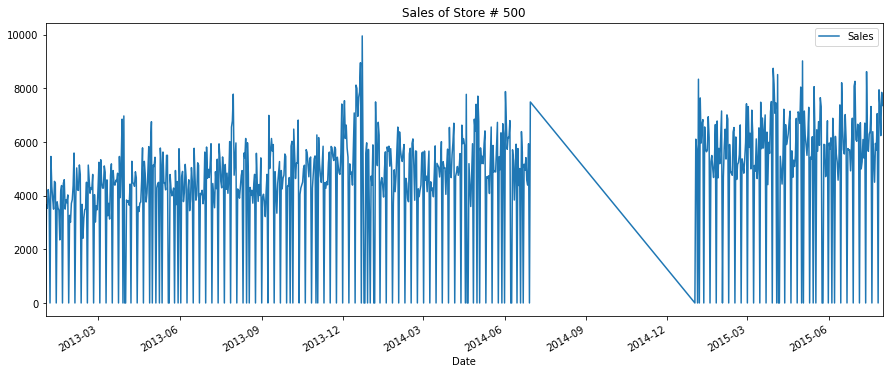

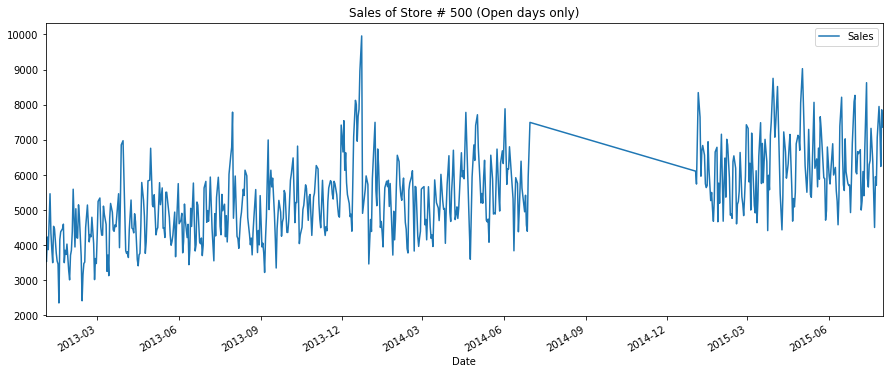

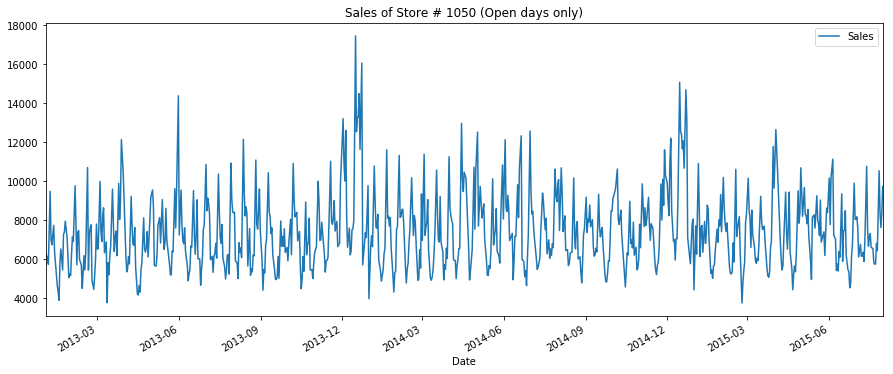

In [4]:
# convert type of Date field to datetime 
train['Date'] = pd.to_datetime(train['Date'],format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'],format='%Y-%m-%d')


storeId= 500
storesample = train.loc[train['Store']==storeId]
storesample.plot(x='Date',y = 'Sales',figsize = (15,6),title = 'Sales of Store # '+str(storeId))
# plot after removing zero sales
storesample = storesample[storesample['Open'] != 0]
storesample.plot.line(x='Date',y = 'Sales',figsize = (15,6),title = 'Sales of Store # '+str(storeId) + ' (Open days only)')

storeId = 1050
storesample = train.loc[train['Store']==storeId]
storesample = storesample[storesample['Open'] != 0]
storesample.plot.line(x='Date',y = 'Sales',figsize = (15,6),title = 'Sales of Store # '+str(storeId) + ' (Open days only)')

由上面的销售时间序列图所知：
<br>1）部分门店的销售数据有一段缺失，集中在2014-07~2015-01
<br>2）门店的销售没有走势呈周期性波动，没有上升或下降趋势

### 分析数据

In [5]:
# display first 2 records of store.csv
print "sample of store.csv"
display(store.head(2))
# check missing data 
print 'statistics of store.csv'
print pd.concat([(store.isnull().mean()*100).rename('missing%'),store.describe().T],axis =1)


# display first 2 records of train.csv
print "\nsample of  train.csv"
display(train.head(2))
# check missing data 
print 'statistics of train.csv'
print pd.concat([(train.isnull().mean()*100).rename('missing%'),train.describe().T],axis =1)

# display first 2 records of test.csv
print "\nsample of  test.csv"
display(test.head(2))
# check missing data 
print 'statistics of test.csv'
print pd.concat([(test.isnull().mean()*100).rename('missing%'),test.describe().T],axis =1)

sample of store.csv


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


statistics of store.csv
                            missing%   count         mean          std  \
Assortment                  0.000000     NaN          NaN          NaN   
CompetitionDistance         0.269058  1112.0  5404.901079  7663.174720   
CompetitionOpenSinceMonth  31.748879   761.0     7.224704     3.212348   
CompetitionOpenSinceYear   31.748879   761.0  2008.668857     6.195983   
Promo2                      0.000000  1115.0     0.512108     0.500078   
Promo2SinceWeek            48.789238   571.0    23.595447    14.141984   
Promo2SinceYear            48.789238   571.0  2011.763573     1.674935   
PromoInterval              48.789238     NaN          NaN          NaN   
Store                       0.000000  1115.0   558.000000   322.017080   
StoreType                   0.000000     NaN          NaN          NaN   

                              min     25%     50%     75%      max  
Assortment                    NaN     NaN     NaN     NaN      NaN  
CompetitionDistance    

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


statistics of train.csv
               missing%      count         mean          std  min     25%  \
Customers           0.0  1017209.0   633.145946   464.411734  0.0   405.0   
Date                0.0        NaN          NaN          NaN  NaN     NaN   
DayOfWeek           0.0  1017209.0     3.998341     1.997391  1.0     2.0   
Open                0.0  1017209.0     0.830107     0.375539  0.0     1.0   
Promo               0.0  1017209.0     0.381515     0.485759  0.0     0.0   
Sales               0.0  1017209.0  5773.818972  3849.926175  0.0  3727.0   
SchoolHoliday       0.0  1017209.0     0.178647     0.383056  0.0     0.0   
StateHoliday        0.0        NaN          NaN          NaN  NaN     NaN   
Store               0.0  1017209.0   558.429727   321.908651  1.0   280.0   

                  50%     75%      max  
Customers       609.0   837.0   7388.0  
Date              NaN     NaN      NaN  
DayOfWeek         4.0     6.0      7.0  
Open              1.0     1.0      1.0  


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


statistics of test.csv
               missing%    count          mean           std  min       25%  \
Date           0.000000      NaN           NaN           NaN  NaN       NaN   
DayOfWeek      0.000000  41088.0      3.979167      2.015481  1.0      2.00   
Id             0.000000  41088.0  20544.500000  11861.228267  1.0  10272.75   
Open           0.026772  41077.0      0.854322      0.352787  0.0      1.00   
Promo          0.000000  41088.0      0.395833      0.489035  0.0      0.00   
SchoolHoliday  0.000000  41088.0      0.443487      0.496802  0.0      0.00   
StateHoliday   0.000000      NaN           NaN           NaN  NaN       NaN   
Store          0.000000  41088.0    555.899533    320.274496  1.0    279.75   

                   50%       75%      max  
Date               NaN       NaN      NaN  
DayOfWeek          4.0      6.00      7.0  
Id             20544.5  30816.25  41088.0  
Open               1.0      1.00      1.0  
Promo              0.0      1.00      1.0  
S

通过数据缺失值检查可知，store.csv有6个字段有缺失值，其中五个字段缺省比例很高，train.csv文件没有缺失值，test.csv文件有1个字段有缺失值。这些缺失值需要在数据预处理环节进行处理。

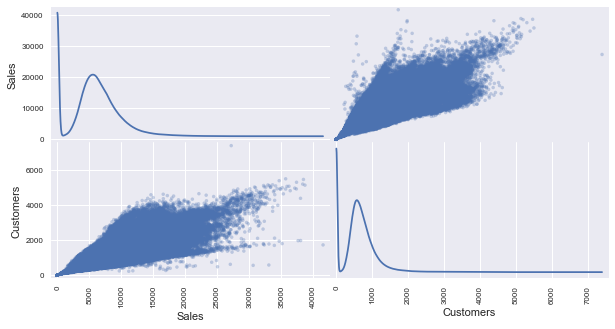

In [410]:
## analyze correlation of continuious fields: Sales and Customers
#sns.pairplot(train[['Sales','Customers']], size=10, diag_kind="kde")
pd.plotting.scatter_matrix(train[['Sales','Customers']], alpha = 0.3, figsize = (10,5), diagonal = 'kde');

观察Sales和Cusotmers散布矩阵图可知，
<br>1）两者都有大量数值为0的记录数，和门店是否开门有关，需要在预处理中排除。
<br>2）Sales和Customers具有高度相关性，业务上也可以理解，门店的销售额和客流量成正相关
<br>3）Sales和Customers的分布具有高度倾斜性，

Number of records with store open but zero sales: 54


D:\Software\Anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[<matplotlib.text.Text at 0xa6fdd68>, <matplotlib.text.Text at 0x129c93c8>]

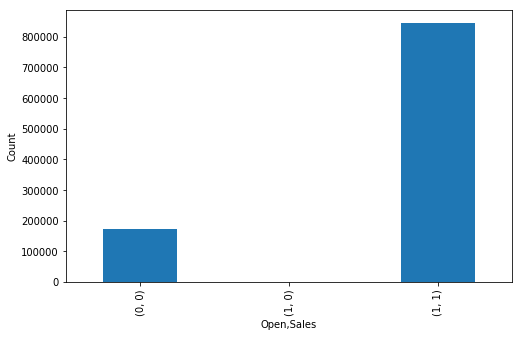

In [6]:
#check how many records with sales zero but still open
print 'Number of records with store open but zero sales:',\
    train[(train['Open']==1)&(train['Sales']==0)]['Sales'].apply(lambda x: 0 if x == 0 else 1).value_counts()[0]
#train['Sales'].plot.hist(alpha=0.5,figsize = (10,5))

opensales = train[['Open','Sales']]
opensales['SalesFlag'] = opensales['Sales'].apply(lambda x: 0 if x ==0 else 1)
#opensales['OpenSalesFlag'] = opensales['Open'].map(str)+opensales['SalesFlag'].map(str)
ax = opensales.groupby(['Open','SalesFlag']).count().plot(kind ='bar',legend=False,figsize = (8,5))
ax.set(xlabel = 'Open,Sales',ylabel = 'Count')

可知大部分销售额是0的是由于店铺关门，店铺营业时销售额为0大概有54条记录，相对数据集来说非常少，可以考虑舍弃。另，预测时我们可以只预测店铺开门时的销售，不开门时销售额设置为0。

### 异常值检测

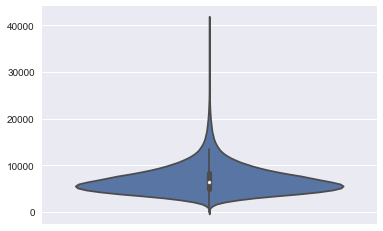

In [412]:
# Violin plot of Sales 
#train['all'] = ''
#sns.violinplot(x='all',y='Sales',hue = 'Promo', data=train[train['Open']==1], size=6)
sns.violinplot(y=['Sales'], data=train[train['Open']==1], size=6)

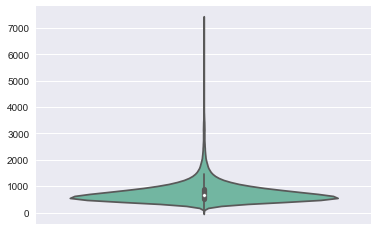

In [413]:
# Violin plot of Customers
#sns.violinplot(x='all',y ='Customers',hue = 'Promo', data=train[train['Open']==1], size=6)
sns.violinplot(y=['Customers'], data=train[train['Open']==1], size=6,palette = 'Set2')

上图分别是Sales和Customers字段的vilionlin plot,可见两图有明显的远离正常值的数据点，大约是中间值的10倍左右，或许是促销所致，暂不处理。

In [414]:
#sns.set(style="darkgrid")
#sns.countplot(x='Open',data=train, palette="Set2")
#traincols = ['Open','Promo','SchoolHoliday','StateHoliday']
#storecols = ['Assortment','Comp']
#np.array_str((train['Open']).unique())

## 数据预处理

### 缺失值处理

In [7]:
# fill na values of field 'CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear' with median value
store['CompetitionDistance'].fillna(0,inplace=True)
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median(),inplace=True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(),inplace=True)

# fill Promo2SinceWeek, Promo2SinceYear,PromoInterval with 0 or None
store['Promo2SinceWeek'].fillna(0,inplace=True)
store['Promo2SinceYear'].fillna(0,inplace=True)
store['PromoInterval'].fillna('None',inplace=True)

#fill open field with 1 in test.csv
test['Open'].fillna(1,inplace=True)

### 数据集合并

In [8]:
# merge store.csv and train.csv
trainnew = pd.merge(train,store,on = 'Store')
display(trainnew.head(2))
# merge store.csv and test.csv
testnew = pd.merge(test,store,on = 'Store')
#display(test.head(2))

# remove records with sales = 0
feature = trainnew[trainnew['Sales'] != 0]
del trainnew

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None


### 创建特征和目标

In [9]:
#convert date to feature: day, month, year
mindate = feature['Date'].min()
feature['Day']=feature['Date'].dt.day
feature['Month']=feature['Date'].dt.month
feature['Year']=feature['Date'].dt.year
feature['Week']=(np.floor((feature['Date'] - mindate).dt.days/7) +1).astype(int)
feature['DayofYear']=feature['Date'].dt.dayofyear
feature['Quarter']=feature['Date'].dt.quarter

testnew['Day']=testnew['Date'].dt.day
testnew['Month']=testnew['Date'].dt.month
testnew['Year']=testnew['Date'].dt.year
testnew['Week']=(np.floor((testnew['Date'] - mindate).dt.days/7) +1).astype(int)
testnew['DayofYear']=testnew['Date'].dt.dayofyear
testnew['Quarter']=testnew['Date'].dt.quarter

# one hot encoding for categorial fields StoreType and Assortment
##replace exception value in StateHoliday first
feature['StateHoliday'].replace(to_replace = 0L,value ='0',inplace=True)

feature = pd.get_dummies(feature,columns=['StoreType','Assortment','StateHoliday'])
testnew = pd.get_dummies(testnew,columns=['StoreType','Assortment','StateHoliday'])
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(store['PromoInterval'])
feature['PromoInterval_Code'] = le.transform(feature['PromoInterval'])
testnew['PromoInterval_Code'] = le.transform(testnew['PromoInterval'])

## add missing columns to testnew
testnew['StateHoliday_b'] = 0
testnew['StateHoliday_c'] = 0

In [418]:
# Create new feature CompetitionOpenDays from CompetitionOpenSinceMonth and CompetitionOpenSinceYear
feature['CompetitionOpenDays'] = (feature['Date']- \
    pd.to_datetime(('1/'+feature['CompetitionOpenSinceMonth'].astype(int).apply(str)+ \
                    '/'+feature['CompetitionOpenSinceYear'].astype(int).apply(str)),format='%d/%m/%Y')).dt.days.astype(int)

testnew['CompetitionOpenDays'] = (testnew['Date']- \
    pd.to_datetime(('1/'+testnew['CompetitionOpenSinceMonth'].astype(int).apply(str)+ \
                    '/'+testnew['CompetitionOpenSinceYear'].astype(int).apply(str)),format='%d/%m/%Y')).dt.days.astype(int)



In [419]:
## set CompetitionOpenDays to if it is negative number
feature['CompetitionOpenDays']= feature.apply(lambda row: 0 if row['CompetitionOpenDays']<0 or row['CompetitionDistance'] == 0 \
                                              else row['CompetitionOpenDays'],axis=1)
testnew['CompetitionOpenDays']= testnew.apply(lambda row: 0 if row['CompetitionOpenDays']<0 or row['CompetitionDistance'] == 0 \
                                              else row['CompetitionOpenDays'],axis=1)

In [420]:
#create new feature promo2 based on existing feature: Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval

def calc_promo2(CurrentDate,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval):
    if Promo2 == 0:
        return 0
        
    start_date = datetime.strptime(str(int(Promo2SinceYear))+' '+str(int(Promo2SinceWeek)) +' 1','%Y %W %w')
    CurrentMonth = CurrentDate.strftime('%b')
    PromoInterval = PromoInterval.replace('Sept','Sep')
    PromoInterval = PromoInterval.split(',')
    
        
    if CurrentDate >= start_date and CurrentMonth in PromoInterval :
        return 1
    else:
        return 0
  

#mydate = '2015 40 1'
#print datetime.strptime(mydate,"%Y %W %w").strftime('%b')
#mystr = 'Jan,Oct,Nov'
#mystr = 'None'
#print 'Feb' in mystr.split(',')
#print calc_promo2('2014-10-01',1,22,2014,mystr)
## Create new feature promo2:
feature['Promo2Flag'] = feature.apply(lambda x: calc_promo2(x['Date'],x['Promo2'],\
                                                            x['Promo2SinceWeek'],x['Promo2SinceYear'],\
                                                            x['PromoInterval']),axis = 1)

testnew['Promo2Flag'] = testnew.apply(lambda x: calc_promo2(x['Date'],x['Promo2'],\
                                                            x['Promo2SinceWeek'],x['Promo2SinceYear'],\
                                                            x['PromoInterval']),axis = 1)

In [421]:
# Feature store represents location, locations means customers
# Create new feature: AverageMonthlyCustomers
monthlytotal = feature.groupby(['Store','Month','Year'])['Customers'].sum()
MonthlyAveCustomers = monthlytotal.groupby(level='Store').mean()
MonthlyAveCustomers = pd.DataFrame({'Store':MonthlyAveCustomers.index,'MonthlyAveCustomers':MonthlyAveCustomers.values})
# merge new feature with train and test data
feature = pd.merge(feature,MonthlyAveCustomers,on = 'Store')
testnew = pd.merge(testnew,MonthlyAveCustomers,on = 'Store')


In [422]:
#Store Id also means the size of store, we can create StoreDailySalesAvg to represent the store size
dailySalesAvg = feature.groupby(['Store'])['Sales'].mean()
dailySalesAvg = dailySalesAvg.reset_index().rename(columns = {'Sales':'DailySalesAvg'})
feature = pd.merge(feature,dailySalesAvg,on = 'Store')
testnew = pd.merge(testnew,dailySalesAvg,on = 'Store')


In [423]:
#Create PromoDayNum
feature = feature.sort_values(['Store','Date'])
feature['PromoDayNum'] = feature.Promo.diff().ne(0).cumsum()
feature['PromoDayNum'] = feature.groupby(['Store','PromoDayNum'])['Promo'].cumsum()

testnew = testnew.sort_values(['Store','Date'])
testnew['PromoDayNum'] = testnew.Promo.diff().ne(0).cumsum()
testnew['PromoDayNum'] = testnew.groupby(['Store','PromoDayNum'])['Promo'].cumsum()

#Create Promo2DayNum
feature['Promo2DayNum'] = feature.Promo2Flag.diff().ne(0).cumsum()
feature['Promo2DayNum'] = feature.groupby(['Store','Promo2DayNum'])['Promo2Flag'].cumsum()

testnew['Promo2DayNum'] = testnew.Promo2Flag.diff().ne(0).cumsum()
testnew['Promo2DayNum'] = testnew.groupby(['Store','Promo2DayNum'])['Promo2Flag'].cumsum() 

In [424]:
#Create feature PrevMonthSales 
monthlytotalSales = feature.groupby(['Store','Month','Year'])['Sales'].median().reset_index()
monthlytotalSales['Month'] = monthlytotalSales['Month'].apply(lambda x: x+1 if x!=12 else 1)
monthlytotalSales['Year'] = monthlytotalSales.apply(lambda row: row['Year'] +1 if row['Month'] ==1 else row['Year'],axis=1)
monthlytotalSales.rename(columns = {'Sales':'PrevMonthSales'},inplace = True)
feature = pd.merge(feature,monthlytotalSales,how = 'left',on = ['Store','Year','Month'])
testnew = pd.merge(testnew,monthlytotalSales,how = 'left',on = ['Store','Year','Month'])
#fill NAs with 0
#feature = feature[~feature['PrevMonthSales'].isnull()]
feature['PrevMonthSales'].fillna(0,inplace = True)

## fill NAs for testnew with prev 2 month sales
mask = (monthlytotalSales.Year ==2015) & (monthlytotalSales.Month == 8)
tempsales = monthlytotalSales[mask]
tempsales.Month = 9
tempsales.rename(columns = {'PrevMonthSales':'TempSales'},inplace = True)
testnew['TempSales'] = pd.merge(testnew,tempsales,how = 'left',on = ['Store','Year','Month'])['TempSales']
testnew['PrevMonthSales'] = testnew.apply(lambda row: row['TempSales'] if np.isnan(row['PrevMonthSales'])\
                                          else row['PrevMonthSales'],axis=1)
testnew.drop(['TempSales'],axis=1,inplace=True)

D:\Software\Anaconda2\envs\py2\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [425]:
#StateHoliday for last,current,next week
holiday = feature[['Store','Date','Week','StateHoliday_a','StateHoliday_b','StateHoliday_c','SchoolHoliday']]
holiday =holiday.append(testnew[['Store','Date','Week','StateHoliday_a','StateHoliday_b','StateHoliday_c','SchoolHoliday']])

holiday['Holiday'] = holiday['StateHoliday_a'] + holiday['StateHoliday_b'] + \
                            holiday['StateHoliday_c'] + holiday['SchoolHoliday']
holidayWeek = holiday.groupby(['Store','Week'])['Holiday'].sum().reset_index()
holidayWeek = holidayWeek[holidayWeek['Holiday']!=0]
holiday.drop(['Holiday'],axis=1,inplace=True)
#holiday
holiday = pd.merge(holiday,holidayWeek, how = 'left',on = ['Store','Week']).\
        rename(columns={'Holiday':'Currentweek_Holiday'}).fillna(0)
# next week (assign current week data to previous week)
holidayWeek['Week'] = holidayWeek['Week'] -1 
holiday = pd.merge(holiday,holidayWeek, how = 'left',on = ['Store','Week']).\
        rename(columns={'Holiday':'Nextweek_Holiday'}).fillna(0)
# previous week (assign current week data to next week)
holidayWeek['Week'] = holidayWeek['Week'] +1 
holiday = pd.merge(holiday,holidayWeek, how = 'left',on = ['Store','Week']).\
        rename(columns={'Holiday':'Lastweek_Holiday'}).fillna(0)
# 
holiday = holiday[['Store','Date','Nextweek_Holiday','Lastweek_Holiday','Currentweek_Holiday']]
feature = pd.merge(feature,holiday,on= ['Store','Date'])
testnew = pd.merge(testnew,holiday,on= ['Store','Date'])

In [426]:
#Create feature PrevQuarterSales 
qtrtotalSales = feature.groupby(['Store','Quarter','Year'])['Sales'].median().reset_index()
qtrtotalSales['Quarter'] = qtrtotalSales['Quarter'].apply(lambda x: x+1 if x!=4 else 1)
qtrtotalSales['Year'] = qtrtotalSales.apply(lambda row: row['Year'] +1 if row['Quarter'] ==1 else row['Year'],axis=1)
qtrtotalSales.rename(columns = {'Sales':'PrevQuarterSales'},inplace = True)
feature = pd.merge(feature,qtrtotalSales,how = 'left',on = ['Store','Year','Quarter'])
testnew = pd.merge(testnew,qtrtotalSales,how = 'left',on = ['Store','Year','Quarter'])
#fill NAs with 0
feature['PrevQuarterSales'].fillna(0,inplace = True)
testnew['PrevQuarterSales'].fillna(0,inplace = True)


In [427]:
#Create feature LastYearSMSales - last year same month sales
lastYearMonthlySales = feature.groupby(['Store','Month','Year'])['Sales'].median().reset_index()
lastYearMonthlySales['Year'] = lastYearMonthlySales['Year'] + 1

lastYearMonthlySales.rename(columns = {'Sales':'LastYearSMSales'},inplace = True)
feature = pd.merge(feature,lastYearMonthlySales,how = 'left',on = ['Store','Year','Month'])
testnew = pd.merge(testnew,lastYearMonthlySales,how = 'left',on = ['Store','Year','Month'])
#fill NAs with 0
feature['LastYearSMSales'].fillna(0,inplace = True)
testnew['LastYearSMSales'].fillna(0,inplace = True)


In [428]:
#feature - StorePromoSales 
storePromoSales = feature.groupby(['Store','Promo'])['Sales'].median()
storePromoSales = storePromoSales.reset_index().rename(columns = {'Sales':'StorePromoSales'})
feature = pd.merge(feature,storePromoSales, how = 'left',on = ['Store','Promo'])
testnew = pd.merge(testnew,storePromoSales, how ='left',on = ['Store','Promo'])
##fill NAs with 0
feature['StorePromoSales'].fillna(0,inplace = True)
testnew['StorePromoSales'].fillna(0,inplace = True)

#feature - StorePromo2Sales 
storePromo2Sales = feature.groupby(['Store','Promo2Flag','Month'])['Sales'].median()
storePromo2Sales = storePromo2Sales.reset_index().rename(columns = {'Sales':'StorePromo2Sales'})
feature = pd.merge(feature,storePromo2Sales, how = 'left',on = ['Store','Promo2Flag','Month'])
testnew = pd.merge(testnew,storePromo2Sales, how ='left',on = ['Store','Promo2Flag','Month'])
##fill NAs with 0
feature['StorePromo2Sales'].fillna(0,inplace = True)
testnew['StorePromo2Sales'].fillna(0,inplace = True)

In [429]:
# feature - StoreSchoolHolidaySales
storeSchHolSales = feature.groupby(['Store','SchoolHoliday','Month'])['Sales'].median()
storeSchHolSales = storeSchHolSales.reset_index().rename(columns = {'Sales':'StoreSchHolSales'})
feature = pd.merge(feature,storeSchHolSales, how = 'left',on = ['Store','SchoolHoliday','Month'])
testnew = pd.merge(testnew,storeSchHolSales, how ='left',on = ['Store','SchoolHoliday','Month'])
##fill NAs with 0
feature['StoreSchHolSales'].fillna(0,inplace = True)
testnew['StoreSchHolSales'].fillna(0,inplace = True)


In [430]:
#delete unusable fields
droplist = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',\
            'Promo2SinceWeek','Promo2SinceYear','PromoInterval','Customers','Month','Quarter','Week',\
            'StateHoliday_a','StateHoliday_b','StateHoliday_c','StateHoliday_0'
           ]
feature.drop(droplist,axis=1,inplace=True,errors = 'ignore')
testnew.drop(droplist,axis=1,inplace=True,errors = 'ignore')

In [431]:
feature.Year = feature.Year.astype(int)
testnew.Year = testnew.Year.astype(int)

### 特征变换

转换倾斜分布的数据

In [432]:
## Transform skewed sales data
feature_unlogged = feature
test_unlogged = testnew

feature['log_Sales'] = np.log(feature['Sales'])

#skewed data
skewed =['PrevMonthSales','PrevQuarterSales','StorePromoSales','StorePromo2Sales','StoreSchHolSales',\
         'LastYearSMSales','DailySalesAvg','MonthlyAveCustomers'
        ]

feature[skewed] = feature[skewed].apply(lambda x: np.log(x+1))
testnew[skewed] = testnew[skewed].apply(lambda x: np.log(x+1))

#Scale features which has large value
#for decision tree algorithm, scaling is not necessary
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler_features = ['CompetitionDistance','Year','MonthlyAveCustomers','CompetitionOpenDays',\
#                   'DailySalesAvg','PrevMonthSales',
#                   'PrevQuarterSales',
#                   'LastYearSMSales',
#                   'StorePromoSales',
#                  'StorePromo2Sales','StoreSchHolSales'
#                  ]
#scaler.fit(feature[scaler_features])
#feature[scaler_features] = scaler.transform(feature[scaler_features])
#testnew[scaler_features] = scaler.transform(testnew[scaler_features])



由于训练数据包含时间序列，因此将训练集的最后6周数据作为验证集，之前的数据作为训练集

In [433]:
# Data split
feature['Date'] = feature['Date'].astype('datetime64[ns]')
maxTrainDate = np.max(feature['Date'])
days = timedelta(days=42)

# creat training and validation dataset
X_train = feature[feature['Date']<= (maxTrainDate - days)].drop(['Sales','log_Sales'],axis=1)
X_val = feature[feature['Date']> (maxTrainDate - days)].drop(['Sales','log_Sales'],axis=1)

Y_train = feature[feature['Date']<= (maxTrainDate - days)][['Store','log_Sales']]
Y_val = feature[feature['Date']> (maxTrainDate - days)][['Store','log_Sales']]

# drop Date column
X_train.drop(['Date'],axis=1,inplace=True)
X_val.drop(['Date'],axis=1,inplace=True)
X_test = testnew.drop(['Date'],axis=1)

### 保存数据

In [434]:
import pickle

data = {'X_train':X_train,
        'Y_train':Y_train,
        'X_val':X_val,
        'Y_val':Y_val,
        'X_test':X_test
       }

pklfile = open('processeddata.pkl','wb')
pickle.dump(data,pklfile)
pklfile.close()

print 'Data saved to processeddata.pkl'

Data saved to processeddata.pkl


## 模型评价指标和朴素预测器

### 导入数据

In [46]:
import pickle
#load data from pickle

pklfile = open('processeddata.pkl','rb')
data= pickle.load(pklfile)
pklfile.close()

# load data
X_train = data['X_train']
Y_train = data['Y_train']
X_val = data['X_val']
Y_val = data['Y_val']
X_test = data['X_test']

X_all = X_train.append(X_val).append(X_test.drop(['Id'],axis=1))

本项目要预测的是具有连续数据属性的销售额，我们以RMPSE（Rooted Mean Percentage Squared Error）指标来衡量预测结果的准确率
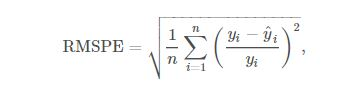
其中yi是某店在某日的实际销售额，ˆ yi是对应的预测值，一般情况下RMPSE的0.0~1.0之间，RMPSE值越小，准确率越高。如果任一店的任一日实际销售额yi为0，则不计入公式中。

In [11]:
def calc_RMPSE(y_act,y_pred):
    y_act = np.exp(y_act)
    y_pred = np.exp(y_pred)
    return np.sqrt(np.square((y_act - y_pred)/y_act).mean())

## create custom evaluation metric for XGBoost
def RMPSE_eval(y_pred,y_act): 
    y_act = y_act.get_label()
    
    return 'RMPSE_eval',calc_RMPSE(y_act,y_pred)

#y_act = pd.Series([1,2,3])
#y_pred = pd.Series([2,2,4])
#print 'RMSPE:',calc_RMSPE(y_act,y_pred)

### 朴素预测器

假设有一个简单的模型，该模型以每个门店的平均每日销售额作为该门店未来的每日预测值，然后用验证集来验证，该模型会表现如何呢？

In [12]:
# Train naive model 
#Y_train.groupby(['Store']).mean().reset_index()
simpleModel = Y_train.groupby(['Store'],as_index=False).mean()

Y_pred = pd.merge(Y_val,simpleModel,on='Store')
Y_pred =Y_pred.rename(columns={'log_Sales_x':'log_Sales_Act','log_Sales_y':'log_Sales_Pred'})

score_rmpse = calc_RMPSE(Y_pred['log_Sales_Act'],Y_pred['log_Sales_Pred'])

print 'RMPSE score for naive model: {:.5f}'.format(score_rmpse)

RMPSE score for naive model: 0.30412


朴素预测器的模型得分是0.30412，效果当然很一般但是也不算太差

## 监督学习

此项们要求预测的是连续数据销售额，故应选择回归模型，按照以往的经验，这里选择从简单到复杂的三个模型，先进行初步比较,看哪个模型最适合。
<br> 决策树回归模型
<br> 随机森林模型
<br> XGBoost模型（极速梯度提升模型）

### 创建模型训练框架

In [13]:
# load data

X_train = data['X_train'].drop(['Store'],axis =1)
Y_train = data['Y_train'].drop(['Store'],axis =1).iloc[:,0]
X_val = data['X_val'].drop(['Store'],axis =1)
Y_val = data['Y_val'].drop(['Store'],axis =1).iloc[:,0]
X_test = data['X_test'].drop(['Store'],axis =1)


In [14]:
from time import time

def train_predict(learner, X_train,Y_train,X_val,Y_val):
    # create dictionary to store train / prediction time and score
    results = {}
    
    # training model
    start = time()
    learner.fit(X_train,Y_train)
    end = time()
    
    results['train_time'] = end-start
    
    # prediction
    start = time()
    pred_train = learner.predict(X_train)
    pred_val = learner.predict(X_val)
    end = time()
    
    results['prediction_time'] = end - start
    
    # score
    start = time()
    results['RMPSE_train'] = calc_RMPSE(Y_train,pred_train)
    results['RMPSE_val'] = calc_RMPSE(Y_val,pred_val)
    end = time()
    
    #output
    print '{} trained on models'.format(learner.__class__.__name__)
    
    return results

### 模型初始评估

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import make_scorer
import xgboost as xgb

In [171]:
clf_A = DecisionTreeRegressor(random_state = 427)
clf_B = RandomForestRegressor(random_state = 427)
clf_C = XGBRegressor()

clfresults = {}
for clf in [clf_A,clf_B,clf_C]:
    clf_name = clf.__class__.__name__
    clfresults[clf_name] = train_predict(clf,X_train,Y_train,X_val,Y_val)
    
print clfresults    

DecisionTreeRegressor trained on models
RandomForestRegressor trained on models
XGBRegressor trained on models
{'RandomForestRegressor': {'train_time': 155.24200010299683, 'prediction_time': 3.994999885559082, 'RMSPE_val': 0.15211665330519819, 'RMSPE_train': 0.049442707325469321}, 'XGBRegressor': {'train_time': 72.10199999809265, 'prediction_time': 2.698000192642212, 'RMSPE_val': 0.17838197752107118, 'RMSPE_train': 0.24075843323768245}, 'DecisionTreeRegressor': {'train_time': 22.098000049591064, 'prediction_time': 0.7439999580383301, 'RMSPE_val': 0.21544569296616814, 'RMSPE_train': 2.9995963564703907e-05}}


In [177]:
## convert dictionary Results to dataframe
model_eval = pd.DataFrame.from_dict(clfresults).transpose()#.reset_index().rename(columns={'index':'Regressor'})
model_eval = model_eval[['RMSPE_train','RMSPE_val','train_time','prediction_time']]
print model_eval

                       RMSPE_train  RMSPE_val  train_time  prediction_time
DecisionTreeRegressor     0.000030   0.215446      22.098            0.744
RandomForestRegressor     0.049443   0.152117     155.242            3.995
XGBRegressor              0.240758   0.178382      72.102            2.698


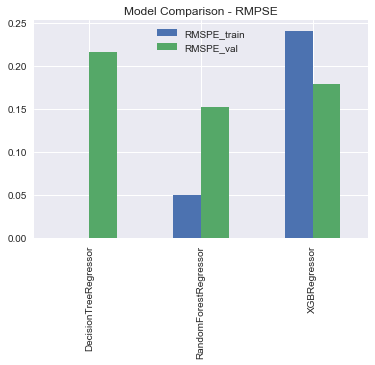

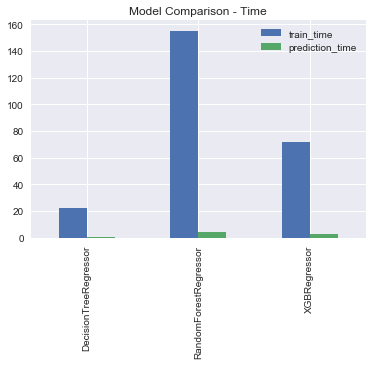

In [178]:
model_eval.iloc[:,0:2].plot(title = 'Model Comparison - RMPSE',kind = 'bar')
model_eval.iloc[:,2:4].plot(title = 'Model Comparison - Time',kind = 'bar')

从上面的模型评分比较来看，决策树和随机森林模型都存在训练集上的表现远胜于验证集上的表现，说明模型的普适性不好，存在过拟合情况。XGBoost算法虽然表现略差，但是在验证集上的表现比训练集上还好，说明模型非常稳健，可以通过参数调优进一步是提升模型的表现。综合考虑，选择XGBoost算法进行进一步优化。


### 模型调优

In [16]:
# Step 1:parameter initialization
xgb_param = {'objective':'reg:linear',
             'tree_method':'hist',
             'grow_policy': 'depthwise',#'lossguide'
             'eta':0.1,
             'max_depth':8,
             'min_child_weight':1,             
             'n_estimators':10000,
             'subsample':0.8,
             'colsample_bytree':0.8,
             'gamma':0,
             'scale_pos_weight':1,
             'alpha': 0,
             'lambda': 1,             
             'seed':400,
             'nthread':-1
             }
xgbTrain = xgb.DMatrix(X_train,Y_train)
xgbVal = xgb.DMatrix(X_val,Y_val)

In [445]:
# step 2: with fixed eta =0.1 and tune tune max_depth, min_child_weight
xgb_param['eta']  = 0.1
max_depth =range(6,12,2)
min_child_weight = range(1,6,2)

#print cvresult
step2_results={}
step2_evals_result={}
for j in max_depth:
    xgb_param['max_depth'] = j
    for k in min_child_weight:
        xgb_param['min_child_weight'] = k
        print 'max_depth={},min_child_weight={}'.format(j,k)

        start = time()
        model = xgb.train(xgb_param,xgbTrain,num_boost_round = xgb_param['n_estimators'],\
                          evals = [(xgbTrain,'train'),(xgbVal,'val')],evals_result = step2_evals_result,\
                          feval = RMPSE_eval,early_stopping_rounds=50,verbose_eval = False)
        end = time()           
        step2_results[str((j,k))] = {'best ite':model.best_iteration, 
                                     'best_score':model.best_score, 
                                     'best_ntree_limit':model.best_ntree_limit,
                                     #'evals_result':step2_evals_result,
                                     'time':'%0.2f'%((end-start)/60)}            
        print step2_results[str((j,k))]


max_depth=6,min_child_weight=1
{'best ite': 770, 'time': '7.31', 'best_ntree_limit': 771, 'best_score': 0.124366}
max_depth=6,min_child_weight=3
{'best ite': 805, 'time': '7.66', 'best_ntree_limit': 806, 'best_score': 0.127319}
max_depth=6,min_child_weight=5
{'best ite': 746, 'time': '7.12', 'best_ntree_limit': 747, 'best_score': 0.124978}
max_depth=8,min_child_weight=1
{'best ite': 665, 'time': '7.91', 'best_ntree_limit': 666, 'best_score': 0.121106}
max_depth=8,min_child_weight=3
{'best ite': 486, 'time': '5.84', 'best_ntree_limit': 487, 'best_score': 0.120961}
max_depth=8,min_child_weight=5
{'best ite': 974, 'time': '11.30', 'best_ntree_limit': 975, 'best_score': 0.11892}
max_depth=10,min_child_weight=1
{'best ite': 404, 'time': '6.97', 'best_ntree_limit': 405, 'best_score': 0.12323}
max_depth=10,min_child_weight=3
{'best ite': 680, 'time': '11.46', 'best_ntree_limit': 681, 'best_score': 0.122413}
max_depth=10,min_child_weight=5
{'best ite': 545, 'time': '8.68', 'best_ntree_limit': 

In [455]:
# step 3:tune gamma

xgb_param['max_depth'] = 8
xgb_param['min_child_weight'] = 5
gamma = [i/10.0 for i in range(0,5)]

step3_results={}

for i in gamma:
    xgb_param['gamma'] = i
    print 'gamma:{}'.format(i)
    start = time()
    model = xgb.train(xgb_param,xgbTrain,num_boost_round = xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],feval = RMPSE_eval,\
                      early_stopping_rounds=100,verbose_eval = False)
    end = time()           
    step3_results[str(i)] = {'best ite':model.best_iteration, 
                              'best_score':model.best_score, 
                              'best_ntree_limit':model.best_ntree_limit,
                              'time':'%0.2f'%((end-start)/60)}            
    print step3_results[str(i)]

gamma:0.0
{'best ite': 974, 'time': '10.87', 'best_ntree_limit': 975, 'best_score': 0.11892}
gamma:0.1
{'best ite': 815, 'time': '8.65', 'best_ntree_limit': 816, 'best_score': 0.119995}
gamma:0.2
{'best ite': 814, 'time': '8.51', 'best_ntree_limit': 815, 'best_score': 0.120334}
gamma:0.3
{'best ite': 1407, 'time': '14.13', 'best_ntree_limit': 1408, 'best_score': 0.122386}
gamma:0.4
{'best ite': 1088, 'time': '10.82', 'best_ntree_limit': 1089, 'best_score': 0.124398}


In [457]:
# step 4:tune subsample
xgb_param['gamma'] = 0

subsample=[i/100.0 for i in range(60,90,5)]

step4_results={}

for i in subsample:
    xgb_param['subsample'] = i
    print 'subsample:{}'.format(i)
    start = time()
    model = xgb.train(xgb_param,xgbTrain,num_boost_round=xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],feval = RMPSE_eval,\
                      early_stopping_rounds=100,verbose_eval = False)
    end = time()           
    step4_results[str(i)] = {'best ite':model.best_iteration, 
                              'best_score':model.best_score, 
                              'best_ntree_limit':model.best_ntree_limit,
                              'time':'%0.2f'%((end-start)/60)}            
    print step4_results[str(i)]


subsample:0.6
{'best ite': 617, 'time': '6.70', 'best_ntree_limit': 618, 'best_score': 0.122054}
subsample:0.65
{'best ite': 840, 'time': '8.51', 'best_ntree_limit': 841, 'best_score': 0.120148}
subsample:0.7
{'best ite': 1225, 'time': '10.90', 'best_ntree_limit': 1226, 'best_score': 0.120102}
subsample:0.75
{'best ite': 994, 'time': '9.03', 'best_ntree_limit': 995, 'best_score': 0.118811}
subsample:0.8
{'best ite': 974, 'time': '9.04', 'best_ntree_limit': 975, 'best_score': 0.11892}
subsample:0.85
{'best ite': 1453, 'time': '16.19', 'best_ntree_limit': 1454, 'best_score': 0.119041}


In [458]:
# step 5:tune colsample_bytree
xgb_param['subsample'] = 0.75

colsample_bytree = [i/100.0 for i in range(60,90,5)]
step5_results={}

for i in subsample:
    xgb_param['colsample_bytree'] = i
    print 'colsample_bytree:{}'.format(i)
    start = time()
    model = xgb.train(xgb_param,xgbTrain,num_boost_round=xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],feval = RMPSE_eval,\
                      early_stopping_rounds=100,verbose_eval = False)
    end = time()           
    step5_results[str(i)] = {'best ite':model.best_iteration, 
                              'best_score':model.best_score, 
                              'best_ntree_limit':model.best_ntree_limit,
                              'time':'%0.2f'%((end-start)/60)}            
    print step5_results[str(i)]


colsample_bytree:0.6
{'best ite': 994, 'time': '10.53', 'best_ntree_limit': 995, 'best_score': 0.118811}
colsample_bytree:0.65
{'best ite': 994, 'time': '9.92', 'best_ntree_limit': 995, 'best_score': 0.118811}
colsample_bytree:0.7
{'best ite': 994, 'time': '10.86', 'best_ntree_limit': 995, 'best_score': 0.118811}
colsample_bytree:0.75
{'best ite': 994, 'time': '11.51', 'best_ntree_limit': 995, 'best_score': 0.118811}
colsample_bytree:0.8
{'best ite': 994, 'time': '11.55', 'best_ntree_limit': 995, 'best_score': 0.118811}
colsample_bytree:0.85
{'best ite': 994, 'time': '10.74', 'best_ntree_limit': 995, 'best_score': 0.118811}


In [460]:
# step 6: tune alpha
xgb_param['colsample_bytree'] = 0.8

alpha = [0, 0.001, 0.005, 0.01, 0.05]
step6_results={}

for i in alpha:
    xgb_param['alpha'] = i
    print 'alpha:',i
    start = time()
    model = xgb.train(xgb_param,xgbTrain,num_boost_round=xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],feval = RMPSE_eval,\
                      early_stopping_rounds=100,verbose_eval = False)
    end = time()           
    step6_results[str(i)] = {'best ite':model.best_iteration, 
                              'best_score':model.best_score, 
                              'best_ntree_limit':model.best_ntree_limit,
                              'time':'%0.2f'%((end-start)/60)}            
    print step6_results[str(i)]

alpha: 0
{'best ite': 994, 'time': '11.11', 'best_ntree_limit': 995, 'best_score': 0.118811}
alpha: 0.001
{'best ite': 1332, 'time': '14.61', 'best_ntree_limit': 1333, 'best_score': 0.118173}
alpha: 0.005
{'best ite': 780, 'time': '9.33', 'best_ntree_limit': 781, 'best_score': 0.120268}
alpha: 0.01
{'best ite': 1087, 'time': '11.56', 'best_ntree_limit': 1088, 'best_score': 0.122165}
alpha: 0.05
{'best ite': 1286, 'time': '13.30', 'best_ntree_limit': 1287, 'best_score': 0.118383}


In [462]:
# step 8: tune lambda
xgb_param['alpha'] = 0.001

lambdaval = range(1,10)
step8_results={}

for i in lambdaval:
    xgb_param['lambda'] = i
    print 'lambda:',i
    start = time()
    model = xgb.train(xgb_param,xgbTrain,num_boost_round=xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],feval = RMPSE_eval,\
                      early_stopping_rounds=100,verbose_eval = False)
    end = time()           
    step8_results[str(i)] = {'best ite':model.best_iteration, 
                              'best_score':model.best_score, 
                              'best_ntree_limit':model.best_ntree_limit,
                              'time':'%0.2f'%((end-start)/60)}            
    print step8_results[str(i)]

lambda: 1
{'best ite': 1332, 'time': '16.21', 'best_ntree_limit': 1333, 'best_score': 0.118173}
lambda: 2
{'best ite': 778, 'time': '10.59', 'best_ntree_limit': 779, 'best_score': 0.120027}
lambda: 3
{'best ite': 1372, 'time': '15.70', 'best_ntree_limit': 1373, 'best_score': 0.119696}
lambda: 4
{'best ite': 1463, 'time': '18.59', 'best_ntree_limit': 1464, 'best_score': 0.12004}
lambda: 5
{'best ite': 1424, 'time': '15.60', 'best_ntree_limit': 1425, 'best_score': 0.117909}
lambda: 6
{'best ite': 1551, 'time': '17.45', 'best_ntree_limit': 1552, 'best_score': 0.117119}
lambda: 7
{'best ite': 1532, 'time': '17.15', 'best_ntree_limit': 1533, 'best_score': 0.117323}
lambda: 8
{'best ite': 1242, 'time': '15.07', 'best_ntree_limit': 1243, 'best_score': 0.11573}
lambda: 9
{'best ite': 1368, 'time': '14.60', 'best_ntree_limit': 1369, 'best_score': 0.116376}


In [487]:
# Step 9: lower learning rate and recalculate boost round
xgb_param['lambda']  = 8
eta = [0.001,0.005,0.01,0.02,0.03,0.05,0.1]

step9_results = {}

for i in eta:
    xgb_param['eta'] = i
    print 'eta:',i
    start = time()
    model = xgb.train(xgb_param,xgbTrain,num_boost_round = xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],feval = RMPSE_eval,\
                      early_stopping_rounds = 100,verbose_eval = False)
    end = time()           
    step9_results[str(i)] = {'best ite':model.best_iteration, 
                              'best_score':model.best_score, 
                              'best_ntree_limit':model.best_ntree_limit,
                              'time':'%0.2f'%((end-start)/60)}            
    print step9_results[str(i)]
    

eta: 0.001
{'best ite': 5888, 'time': '65.93', 'best_ntree_limit': 5889, 'best_score': 0.149401}
eta: 0.005
{'best ite': 1170, 'time': '12.69', 'best_ntree_limit': 1171, 'best_score': 0.149766}
eta: 0.01
{'best ite': 583, 'time': '6.70', 'best_ntree_limit': 584, 'best_score': 0.14998}
eta: 0.02
{'best ite': 5796, 'time': '57.24', 'best_ntree_limit': 5797, 'best_score': 0.114631}
eta: 0.03
{'best ite': 2901, 'time': '26.06', 'best_ntree_limit': 2902, 'best_score': 0.115352}
eta: 0.05
{'best ite': 1929, 'time': '19.41', 'best_ntree_limit': 1930, 'best_score': 0.117822}
eta: 0.1
{'best ite': 1242, 'time': '11.28', 'best_ntree_limit': 1243, 'best_score': 0.11573}



### 最优模型

In [17]:
# Step 10: train with final parameters
xgb_param['max_depth'] = 8
xgb_param['min_child_weight'] = 5
xgb_param['colsample_bytree'] = 0.8
xgb_param['subsample'] = 0.75
xgb_param['gamma'] = 0
xgb_param['alpha'] = 0.001
xgb_param['lambda']  = 8
xgb_param['eta'] = 0.02
step10_evals_result = {}

print datetime.now() 
bestmodel = xgb.train(xgb_param,xgbTrain,num_boost_round = xgb_param['n_estimators'],\
                      evals = [(xgbTrain,'train'),(xgbVal,'val')],evals_result = step10_evals_result,\
                      feval = RMPSE_eval,early_stopping_rounds = 100,verbose_eval = False)
  
print datetime.now() 
print 'best iteration:{},best_score:{},best_ntree_limit:{}'\
     .format(bestmodel.best_iteration,bestmodel.best_score,bestmodel.best_ntree_limit)
    


2018-02-11 13:21:04.823000
2018-02-11 14:09:15.691000
best iteration:5796,best_score:0.114631,best_ntree_limit:5797


### 模型验证曲线

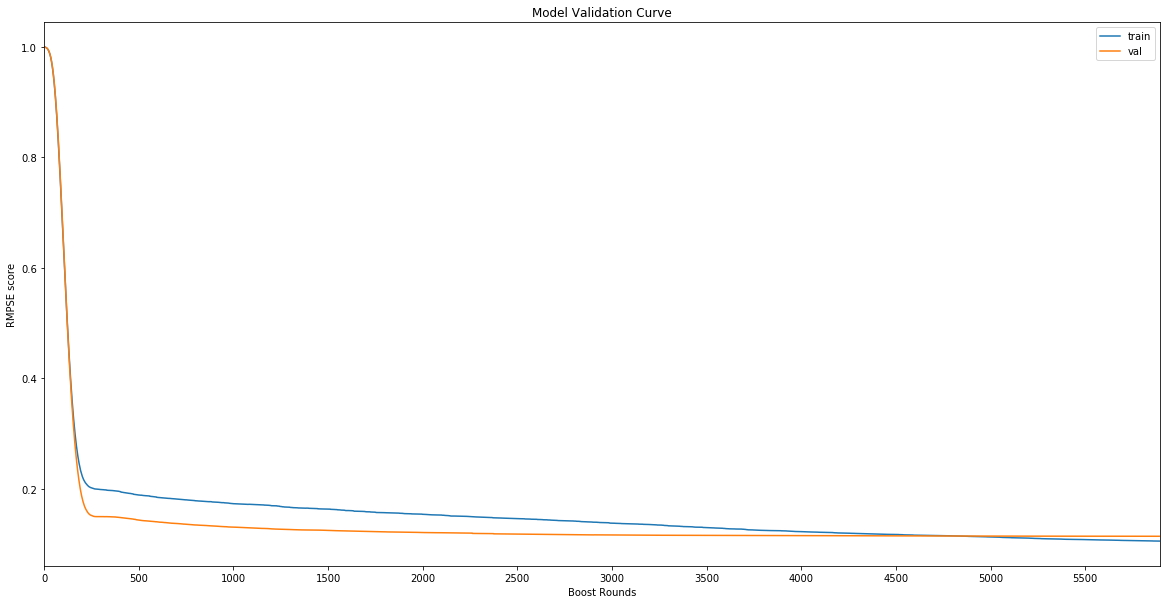

In [18]:
#plot validation curver
complexity_curve = pd.DataFrame(step10_evals_result['train']['RMPSE_eval'],columns = ['train'])
complexity_curve['val'] = pd.DataFrame(step10_evals_result['val']['RMPSE_eval'],columns = ['val'])
ax = complexity_curve.plot(figsize = (20,10),title = 'Model Validation Curve',legend = True)
ax.set_xticks(range(0,6000,500))
ax.set_xlabel('Boost Rounds')
ax.set_ylabel('RMPSE score')

In [19]:
## print RMPSE score on training and validaiton dataset
complexity_curve.min()

train    0.105919
val      0.114631
dtype: float64


### 测试集验证

In [20]:
#Step12 - prediction with test data
# testing
pred_test = bestmodel.predict(xgb.DMatrix(X_test.drop(['Id'],axis=1)),ntree_limit = bestmodel.best_ntree_limit)
Y_test = X_test[['Id','Open']]
Y_test['Sales'] =pd.Series(pred_test)
Y_test['Sales'] = np.exp(Y_test['Sales'])
Y_test['Sales'] = Y_test.apply(lambda row: 0 if row['Open'] ==0 else row['Sales'],axis =1)
Y_test = Y_test.sort_values(['Id'])
Y_test[['Id','Sales']].to_csv('sample_submission.csv',index=False)

D:\Software\Anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Software\Anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\Anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

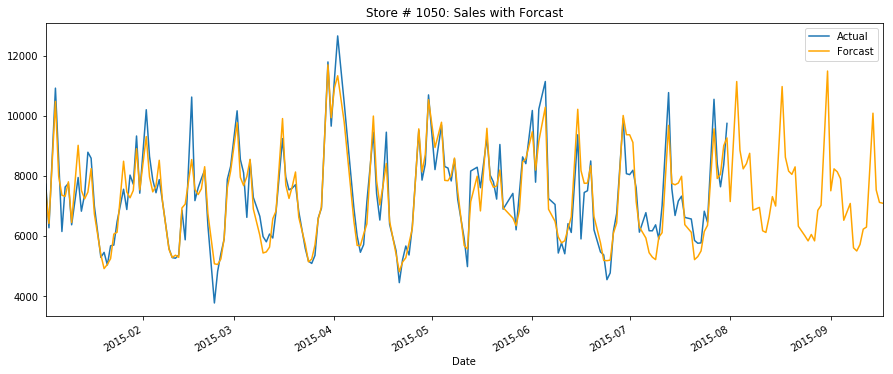

In [66]:
##plot forcast with actual

#pred = bestmodel.predict(xgb.DMatrix(X_all.drop(['Store'],axis=1)),ntree_limit = bestmodel.best_ntree_limit)

X_all['Sales'] = np.exp(pred)
X_all['Date'] = X_all.apply(lambda row: datetime(int(row['Year']),1,1)+timedelta(int(row['DayofYear'])-1),axis = 1)

fig,ax = plt.subplots(figsize = (15,6))
mask1= (train['Store'] == 1050) & (train['Open'] !=0) & (train['Date'] >=datetime(2015,1,1))
train[mask1].plot(ax = ax, x = 'Date', y = 'Sales', kind = 'line',label = 'Actual')
mask2= (X_all['Store'] == 1050) & (X_all['Open'] !=0) & (X_all['Year'] == 2015)
X_all[mask2].plot(ax = ax, x = 'Date', y = 'Sales', kind = 'line',label = 'Forcast',color ='ORANGE')
ax.set_ylabel = 'Sales'
ax.set_title('Store # 1050: Sales with Forcast')



### 特征重要性

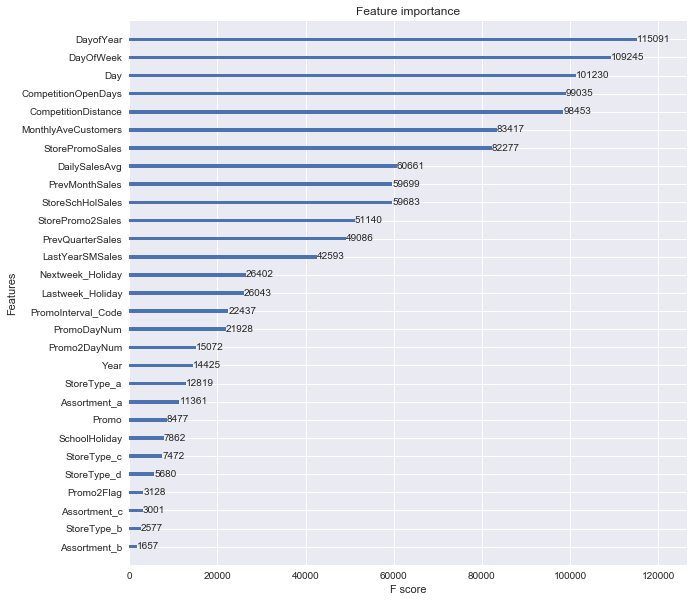

In [519]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
#xgb.plot_importance(clf.booster(),ax=ax)
xgb.plot_importance(bestmodel,ax=ax, importance_type= 'weight')
